## <center> Predicting Listing Gains in the Indian IPO Market Using TensorFlow

I develop a deep learning classification model to predict listing gains for Initial Public Offerings (IPO) in the Indian market. This model can be useful to make investment decisions in the IPO market.

### Preliminary data exploration
The dataset is available under the file name `data.csv` (https://github.com/magorshunov/predicting_ipo_gains/blob/main/data.csv). Listing gains are the percentage increase in the share price of a company from its IPO issue price on the day of listing.
The data consists of following columns:
- `Date`: date when the IPO was listed
- `IPOName`: name of the IPO
- `Issue_Size`: size of the IPO issue, in INR Crores
- `Subscription_QIB`: number of times the IPO was subscribed by the QIB (Qualified Institutional Buyer) investor category
- `Subscription_HNI`: number of times the IPO was subscribed by the HNI (High Networth Individual) investor category
- `Subscription_RII`: number of times the IPO was subscribed by the RII (Retail Individual Investors) investor category
- `Subscription_Total`: total number of times the IPO was subscribed overall
- `Issue_Price`: the price in INR at which the IPO was issued
- `Listing_Gains_Percent`: is the percentage gain in the listing price over the issue price

In [32]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [33]:
df = pd.read_csv('data.csv')
print(df.shape)
df.head()

(319, 9)


,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
0,03/02/10,Infinite Comp,189.80,48.44,106.02,11.08,43.22,165,11.82
1,08/02/10,Jubilant Food,328.70,59.39,51.95,3.79,31.11,145,-84.21
2,15/02/10,Syncom Health,56.25,0.99,16.60,6.25,5.17,75,17.13
3,15/02/10,Vascon Engineer,199.80,1.12,3.65,0.62,1.22,165,-11.28
4,19/02/10,Thangamayil,0.00,0.52,1.52,2.26,1.12,75,-5.20


In [34]:
df.describe(include='all')

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
count,319,319,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
unique,287,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,16/08/21,Infinite Comp,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1192.859969,25.684138,70.091379,8.561599,27.447147,375.128527,4.742696
std,NaN,NaN,2384.643786,40.716782,142.454416,14.508670,48.772203,353.897614,47.650946
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-97.150000
25%,NaN,NaN,169.005000,1.150000,1.255000,1.275000,1.645000,119.000000,-11.555000
50%,NaN,NaN,496.250000,4.940000,5.070000,3.420000,4.930000,250.000000,1.810000
75%,NaN,NaN,1100.000000,34.635000,62.095000,8.605000,33.395000,536.000000,25.310000


In [35]:
df['Listing_Gains_Percent'].describe()

count    319.000000
mean       4.742696
std       47.650946
min      -97.150000
25%      -11.555000
50%        1.810000
75%       25.310000
max      270.400000
Name: Listing_Gains_Percent, dtype: float64

In [36]:
df.isnull().sum()

Date                     0
IPOName                  0
Issue_Size               0
Subscription_QIB         0
Subscription_HNI         0
Subscription_RII         0
Subscription_Total       0
Issue_Price              0
Listing_Gains_Percent    0
dtype: int64

## Exploring the Data
The `Listing_Gains_Percent` target variable is continous. Therfore, I will need to convert it into a categorical variable before I proceed. Approximately 55% of the IPOs listed in profit, and the data is fairly balanced. I have also dropped some of the variables that might not have predictive power. 

In [37]:
df['Listing_Gains_Profit'] = df['Listing_Gains_Percent'].apply(lambda x: 1 if x > 0 else 0)

In [38]:
df['Listing_Gains_Profit'].describe()

count    319.000000
mean       0.545455
std        0.498712
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Listing_Gains_Profit, dtype: float64

In [39]:
df['Listing_Gains_Profit'].value_counts(normalize=True)

Listing_Gains_Profit
1    0.545455
0    0.454545
Name: proportion, dtype: float64

In [40]:
df.drop(['Date ', 'IPOName', 'Listing_Gains_Percent'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Issue_Size            319 non-null    float64
 1   Subscription_QIB      319 non-null    float64
 2   Subscription_HNI      319 non-null    float64
 3   Subscription_RII      319 non-null    float64
 4   Subscription_Total    319 non-null    float64
 5   Issue_Price           319 non-null    int64  
 6   Listing_Gains_Profit  319 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 17.6 KB


## Data Visualization 
I will check for the distribution of predictors with respect to the target variable, since they could be informative for modeling. To do that, I will: 
- Created a countplot to visualize the distribution of the target variable, and give the plot a proper title.
- Used plots to check for the presence of outliers in each of the continuous variables of the dataset.
- Used visualizations to check the relationship between your selected predictor variables and the target variable. Check if segmenting the plots with the distribution of the outcome classes provides any meaningful insight.
- Used visualizations to check if there are correlations between predictor variables.

Here are some of the findings:

1. The histogram and the boxplots show that outliers are present in the data and might need outlier treatment. 

2. The boxplot of `Issue_Price`, with respect to `Listing_Gains_Profit`, shows that there are more outliers for IPOs that listed a loss than there are outliers for IPOs that listed a profit. 

3. The scatterplot shows a correlation between Retail and Total IPO Subscription via a scatterplot.

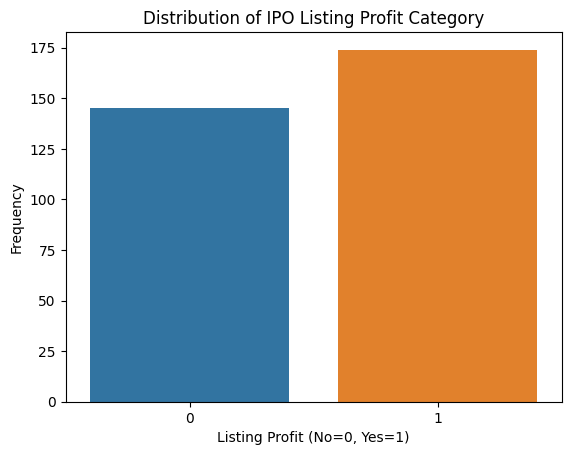

In [41]:
# visualizing the target variable
sns.countplot(x='Listing_Gains_Profit', data=df)
plt.title('Distribution of IPO Listing Profit Category')
plt.xlabel('Listing Profit (No=0, Yes=1)')
plt.ylabel('Frequency')
plt.show()

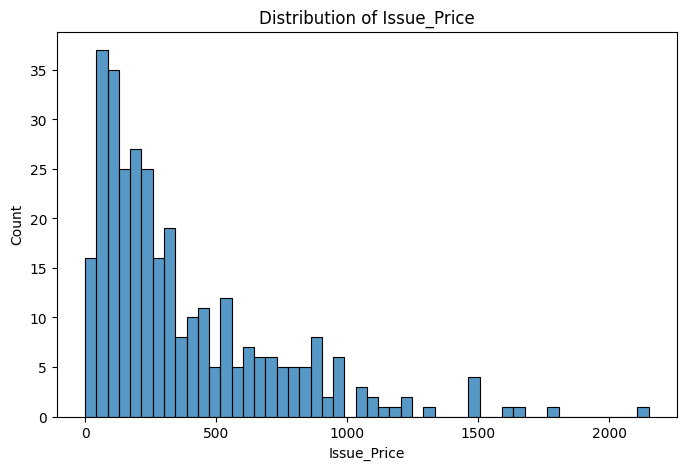

In [42]:
plt.figure(figsize=[8,5])
sns.histplot(data=df, x='Issue_Price', bins=50).set(title='Distribution of Issue_Price', ylabel='Count')
plt.show()

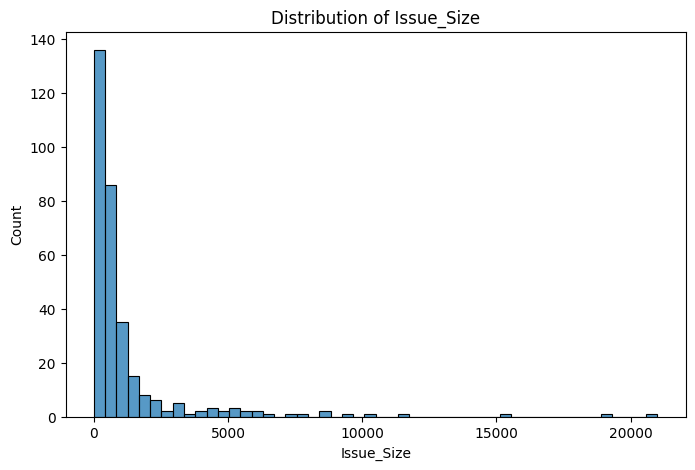

In [43]:
plt.figure(figsize=[8,5])
sns.histplot(data=df, x='Issue_Size', bins=50).set(title='Distribution of Issue_Size', ylabel='Count')
plt.show()

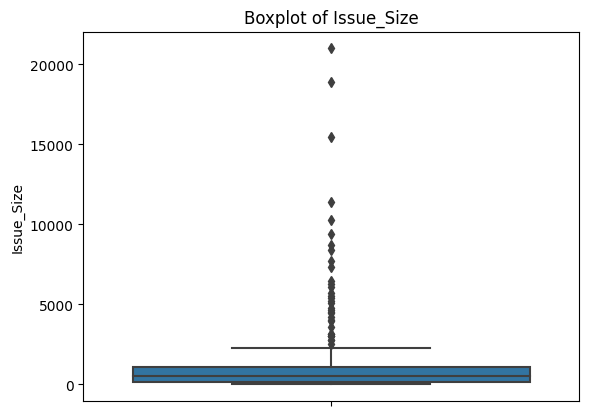

In [44]:
sns.boxplot(data=df, y='Issue_Size')
plt.title('Boxplot of Issue_Size')
plt.show()

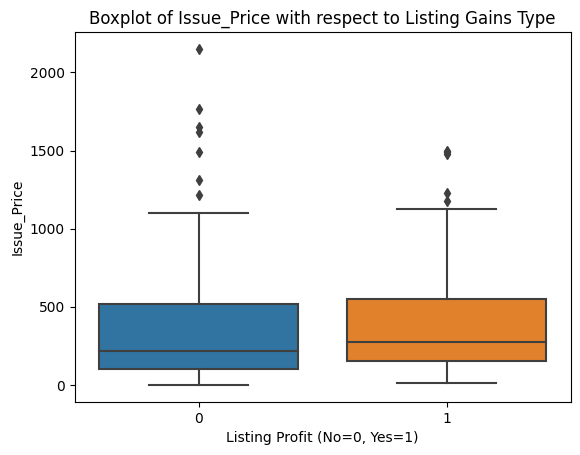

In [45]:
sns.boxplot(data=df, x='Listing_Gains_Profit', y='Issue_Price')
plt.title('Boxplot of Issue_Price with respect to Listing Gains Type')
plt.xlabel('Listing Profit (No=0, Yes=1)')
plt.show()

In [46]:
print(df.skew())

Issue_Size              4.853402
Subscription_QIB        2.143705
Subscription_HNI        3.078445
Subscription_RII        3.708274
Subscription_Total      2.911907
Issue_Price             1.696881
Listing_Gains_Profit   -0.183438
dtype: float64


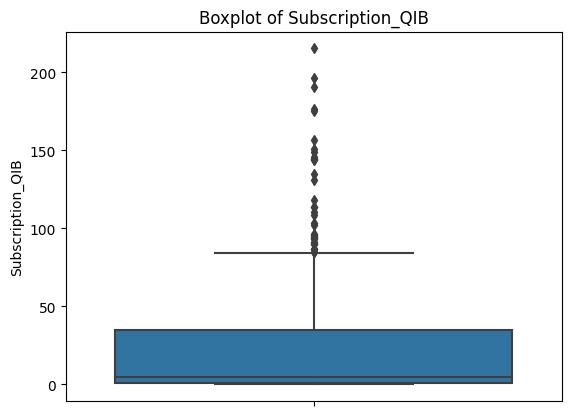

In [47]:
sns.boxplot(data=df, y='Subscription_QIB')
plt.title('Boxplot of Subscription_QIB')
plt.show()

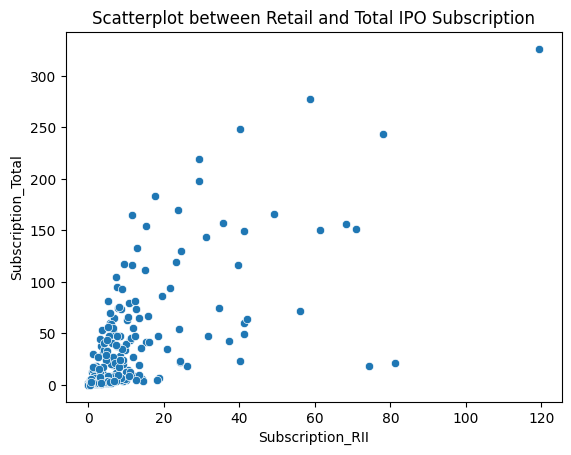

In [48]:
sns.scatterplot(data=df, x='Subscription_RII', y='Subscription_Total')
plt.title('Scatterplot between Retail and Total IPO Subscription')
plt.show()

## Outlier Treatment
Apart from performing a visual inspection, outliers can also be identified with the skewness or the interquartile range (IQR) value. There are different approaches to outlier treatment, but the one I've used here is outlier identification using the interquartile menthod. Once I identified the outliers, I clipped the variable values between the upper and lower bounds.

In [49]:
q1 = df['Issue_Size'].quantile(q=0.25)
q3 = df['Issue_Size'].quantile(q=0.75)  
iqr = q3 - q1   
lower = (q1 - 1.5 * iqr) 
upper = (q3 + 1.5 * iqr) 
print('IQR = ', iqr, '\nlower = ', lower, '\nupper = ', upper, sep='')

IQR = 930.995
lower = -1227.4875000000002
upper = 2496.4925000000003


In [50]:
df['Issue_Size'] = df['Issue_Size'].clip(lower, upper)
df['Issue_Size'].describe()

count     319.000000
mean      763.561238
std       769.689122
min         0.000000
25%       169.005000
50%       496.250000
75%      1100.000000
max      2496.492500
Name: Issue_Size, dtype: float64

In [51]:
q1 = df['Subscription_QIB'].quantile(q=0.25)
q3 = df['Subscription_QIB'].quantile(q=0.75)  
iqr = q3 - q1   
lower = (q1 - 1.5 * iqr) 
upper = (q3 + 1.5 * iqr) 
print('IQR = ', iqr, '\nlower = ', lower, '\nupper = ', upper, sep='')

IQR = 33.48500000000001
lower = -49.07750000000001
upper = 84.86250000000001


In [52]:
df['Subscription_QIB'] = df['Subscription_QIB'].clip(lower, upper)
df['Subscription_QIB'].describe()

count    319.000000
mean      21.521183
std       29.104549
min        0.000000
25%        1.150000
50%        4.940000
75%       34.635000
max       84.862500
Name: Subscription_QIB, dtype: float64

In [53]:
q1 = df['Subscription_HNI'].quantile(q=0.25)
q3 = df['Subscription_HNI'].quantile(q=0.75)  
iqr = q3 - q1   
lower = (q1 - 1.5 * iqr) 
upper = (q3 + 1.5 * iqr) 
print('IQR = ', iqr, '\nlower = ', lower, '\nupper = ', upper, sep='')

IQR = 60.839999999999996
lower = -90.005
upper = 153.355


In [54]:
df['Subscription_HNI'] = df['Subscription_HNI'].clip(lower, upper)
df['Subscription_HNI'].describe()

count    319.000000
mean      40.356426
std       57.427921
min        0.000000
25%        1.255000
50%        5.070000
75%       62.095000
max      153.355000
Name: Subscription_HNI, dtype: float64

In [55]:
q1 = df['Subscription_RII'].quantile(q=0.25)
q3 = df['Subscription_RII'].quantile(q=0.75)  
iqr = q3 - q1   
lower = (q1 - 1.5 * iqr) 
upper = (q3 + 1.5 * iqr) 
print('IQR = ', iqr, '\nlower = ', lower, '\nupper = ', upper, sep='')

IQR = 7.33
lower = -9.72
upper = 19.6


In [56]:
df['Subscription_RII'] = df['Subscription_RII'].clip(lower, upper)
df['Subscription_RII'].describe()

count    319.000000
mean       6.060940
std        6.176882
min        0.000000
25%        1.275000
50%        3.420000
75%        8.605000
max       19.600000
Name: Subscription_RII, dtype: float64

In [57]:
q1 = df['Subscription_Total'].quantile(q=0.25)
q3 = df['Subscription_Total'].quantile(q=0.75)  
iqr = q3 - q1   
lower = (q1 - 1.5 * iqr) 
upper = (q3 + 1.5 * iqr) 
print('IQR = ', iqr, '\nlower = ', lower, '\nupper = ', upper, sep='')

IQR = 31.749999999999996
lower = -45.97999999999999
upper = 81.01999999999998


In [58]:
df['Subscription_Total'] = df['Subscription_Total'].clip(lower, upper)
df['Subscription_Total'].describe()

count    319.000000
mean      20.456646
std       27.217740
min        0.000000
25%        1.645000
50%        4.930000
75%       33.395000
max       81.020000
Name: Subscription_Total, dtype: float64

## Setting the Target and Predictor Variables
Before moving on to modelling, I will:
- Create an array of the target variable (dependent variable).
- Create an array of the predictor variables (independent variables).
- Perform normalization on the predictor variables to scale their values to between 0 and 1.

In [59]:
target_variable = ['Listing_Gains_Profit'] 
predictors = list(set(list(df.columns)) - set(target_variable))
df[predictors] = df[predictors]/df[predictors].max()
df.describe()

,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Profit
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,0.305854,0.253601,0.263157,0.309232,0.252489,0.174478,0.545455
std,0.308308,0.342961,0.374477,0.315147,0.335939,0.164604,0.498712
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.067697,0.013551,0.008184,0.065051,0.020304,0.055349,0.000000
50%,0.198779,0.058212,0.033061,0.174490,0.060849,0.116279,1.000000
75%,0.440618,0.408131,0.404910,0.439031,0.412182,0.249302,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Creating the Holdout Validation Approach
I will use the hold out validation approach to model evaluation. In this approach, I will divide the data in the 70:30 ratio, where I will use 70% of the data for training the model, while I will use the other 30% of the data to test the model.

In [60]:
X = df[predictors].values
y = df[target_variable].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)
print(X_train.shape); print(X_test.shape)

(223, 6)
(96, 6)


## Define the Deep Learning Classification Model
In this step, I've defined the model by instantiating the sequential model class in TensorFlow's Keras. The model architecture is comprised of four hidden layers with `relu` as the activation function. The output layer uses a `sigmoid` activation function, which is a good choice for a binary classification model.

In [61]:
# define model
tf.random.set_seed(100)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(16, activation= 'relu'))
model.add(tf.keras.layers.Dense(8, activation= 'relu'))
model.add(tf.keras.layers.Dense(4, activation= 'relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))    

## Compile and Train the Model
Once I have defined the model, the next steps are to compile and train it. Compiling a model requires specification of the following:
- An optimizer
- A loss function
- An evaluation metric

After compiling the model, I fitted it on the training set. The accuracy improved over epochs. 

In [62]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                224       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
model.fit(X_train, y_train, epochs=250)

Epoch 1/250
7/7 [==============================] - 1s 3ms/step - loss: 0.6899 - accuracy: 0.5874
Epoch 2/250
7/7 [==============================] - 0s 2ms/step - loss: 0.6859 - accuracy: 0.5650
Epoch 3/250
7/7 [==============================] - 0s 1ms/step - loss: 0.6826 - accuracy: 0.5516
Epoch 4/250
7/7 [==============================] - 0s 1ms/step - loss: 0.6771 - accuracy: 0.5561
Epoch 5/250
7/7 [==============================] - 0s 2ms/step - loss: 0.6729 - accuracy: 0.5561
Epoch 6/250
7/7 [==============================] - 0s 2ms/step - loss: 0.6680 - accuracy: 0.5561
Epoch 7/250
7/7 [==============================] - 0s 1ms/step - loss: 0.6629 - accuracy: 0.5561
Epoch 8/250
7/7 [==============================] - 0s 1ms/step - loss: 0.6586 - accuracy: 0.5561
Epoch 9/250
7/7 [==============================] - 0s 1ms/step - loss: 0.6536 - accuracy: 0.5561
Epoch 10/250
7/7 [==============================] - 0s 2ms/step - loss: 0.6493 - accuracy: 0.5561
Epoch 11/250
7/7 [===========

## Model Evaluation
The model evaluation output shows the performance of the model on both training and test data. The accuracy was approximately 75% on the training data and 74% on the test data. It's noteworthy that the training and test set accuracies are close to each other, which shows that there is consistency, and that the accuracy doesn't drop too much when I test the model on unseen data. 

In [64]:
model.evaluate(X_train, y_train)

7/7 [==============================] - 0s 2ms/step - loss: 0.5101 - accuracy: 0.7354


[0.5101242661476135, 0.7354260087013245]

In [65]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 1ms/step - loss: 0.6855 - accuracy: 0.7083


[0.6855059266090393, 0.7083333134651184]

## Conclusion

I have built a deep learning classification model using the deep learning framework, Keras, in TensorFlow. I used a IPO dataset and built a classifier algorithm to predict whether an IPO will list at profit or not. I used the Sequential API to build the model, which is achieving a decent accuracy of 75% and 74% on training and test data, respectively. I see that the accuracy is consistent across the training and test datasets, which is a promising sign. This model can be useful to make investment decisions in the IPO market.


# PS: Alternative Approach via Functional API

In [68]:
input_layer = tf.keras.Input(shape=(X_train.shape[1],))
hidden_layer1 = tf.keras.layers.Dense(128, activation='relu')(input_layer)
drop1 = tf.keras.layers.Dropout(rate=0.40)(hidden_layer1)
hidden_layer2 = tf.keras.layers.Dense(64, activation='relu')(drop1)
drop2 =tf.keras.layers.Dropout(rate=0.20)(hidden_layer2)
hidden_layer3 = tf.keras.layers.Dense(16, activation='relu')(drop2)
hidden_layer4 = tf.keras.layers.Dense(8, activation='relu')(hidden_layer3)
hidden_layer5 = tf.keras.layers.Dense(4, activation='relu')(hidden_layer4)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hidden_layer5)
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
print(model.summary())

optimizer = tf.keras.optimizers.Adam(0.001)

loss = tf.keras.losses.BinaryCrossentropy()

metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.fit(X_train, y_train, epochs=250, verbose=0)
print(model.evaluate(X_train, y_train))
print(model.evaluate(X_test, y_test))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_17 (Dense)            (None, 128)               896       
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 16)                1040      
                                                                 
 dense_20 (Dense)            (None, 8)                 136 